# Colima Inversion Examples



In [1]:
%matplotlib inline
from utils import *
import io_utils as io
import vis_utils as vis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import beta, expon
from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize
from time import process_time
from functools import reduce
from utils import *
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
import re
pd.options.display.float_format = '{:,g}'.format
plt.style.use(['ggplot'])

In [2]:
filename = "./data/colima/colima_real_data.csv"

raw_df, grid = io.import_colima(filename)

grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

display(raw_df.head())

,Sample no.,Easting,Northing,MassArea,Thickness,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius
16,VF00-04a,1499,1506,625.8,60,19,31,18,11,6,2,1,1,1,"2,124.86"
18,VF00-06a3,1957,1997,417.2,40,7,30,25,17,11,5,1,1,1,"2,796.04"
17,VF00-05a3,1787,2173,500.64,48,10,30,24,16,9,3,1,1,1,"2,813.41"
37,VF06-03/5-09,-770,3082,594.51,57,11,25,25,19,11,4,1,1,1,"3,176.73"
31,VF05-08a3,-1673,3152,125.16,12,10,22,24,16,10,4,2,1,1,"3,568.48"


## Preprossessing Steps

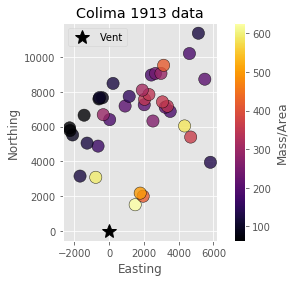

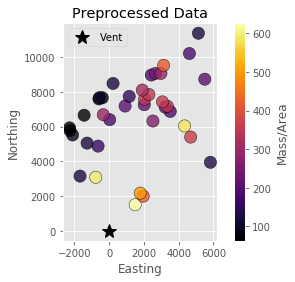

In [18]:
vis.plot_sample(raw_df, vent=(0,0), log=False, title="Colima 1913 data", cbar_label="Mass/Area")
plt.show()
# plt.savefig("colima/all_points.png", dpi=200, format='png')

obs_df = raw_df.copy()

#This is going to be 100 across. Just needs to be the same as the other dfs. 
obs_df["Residual"] = obs_df["MassArea"]/obs_df["MassArea"]

vis.plot_sample(obs_df, vent=(0,0), log=False, title="Preprocessed Data", cbar_label="Mass/Area")
# plt.savefig("colima/All_trans.png", dpi=200, format='png')
plt.show()

In [19]:
grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

t2_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_sim_data.txt")

t2_df["Residual"] = t2_df["MassArea"].values/obs_df["MassArea"].values

display(t2_df.head())

,Easting,Northing,Elevation,MassArea,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius,Residual
16,1499,1506,0,732.73,23.1529,25.4668,22.2407,15.7304,8.99492,3.44384,0.823464,0.136596,0.0103587,"2,124.86",1.17087
18,1957,1997,0,691.154,21.3541,24.7682,22.4602,16.5434,9.82586,3.90198,0.968656,0.164832,0.0128943,"2,796.04",1.65665
17,1787,2173,0,709.841,21.2137,24.71,22.4801,16.6062,9.88889,3.93999,0.980849,0.16722,0.013114,"2,813.41",1.41787
37,-770,3082,0,301.066,13.8022,19.2173,22.1297,20.4626,14.7247,7.12663,2.10569,0.398324,0.0329064,"3,176.73",0.50641
31,-1673,3152,0,149.68,9.51561,14.8613,20.3208,22.2637,18.4942,10.3172,3.45994,0.706562,0.0606982,"3,568.48",1.19591


In [20]:
t2_const_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_const_wind_sim_data.txt")

t2_const_df["Residual"] = t2_const_df["MassArea"]/obs_df["MassArea"]

display(t2_const_df.head())

,Easting,Northing,Elevation,MassArea,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius,Residual
16,1499,1506,2500,"1,394.46",17.2005,24.2121,24.7779,18.9162,10.8457,3.58293,0.449327,0.015328,2.84769e-05,"2,124.86",2.22828
18,1957,1997,2500,"1,216.15",14.016,22.3619,24.864,20.2838,12.7356,4.93885,0.76913,0.0307052,6.30498e-05,"2,796.04",2.91503
17,1787,2173,2500,"1,251",13.877,22.2837,24.8861,20.3522,12.8046,4.98427,0.780754,0.0313104,6.44789e-05,"2,813.41",2.4988
37,-770,3082,2500,359.399,14.8025,22.8299,24.5313,19.4545,12.2828,5.13528,0.922533,0.0410962,9.09858e-05,"3,176.73",0.60453
31,-1673,3152,2500,134.301,15.3664,23.3283,24.4813,18.8191,11.7036,5.16746,1.07907,0.054478,0.000131905,"3,568.48",1.07303


In [21]:
config = io.read_tephra2_config("data/colima/colima_config.txt")

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}

# Update parameters
config["COL_STEPS"] = 20
config["PART_STEPS"] = 9

config["MAX_GRAINSIZE"] = -5
config["MIN_GRAINSIZE"] = 4

# Additional parameter: Constant wind speed
config["WIND_SPEED"] = 10

print("INPUT PARAMETERS:")
display(config)
display(globs)

INPUT PARAMETERS:


{'VENT_EASTING': 0.0,
 'VENT_NORTHING': 0.0,
 'VENT_ELEVATION': 3085.0,
 'PLUME_HEIGHT': 24000.0,
 'ALPHA': 1.02,
 'BETA': 1.56,
 'ERUPTION_MASS': 55000000000.0,
 'MAX_GRAINSIZE': -5,
 'MIN_GRAINSIZE': 4,
 'MEDIAN_GRAINSIZE': -1.8,
 'STD_GRAINSIZE': 2.4,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 4016.0,
 'FALL_TIME_THRESHOLD': 6458.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 20,
 'PART_STEPS': 9,
 'PLUME_MODEL': 2.0,
 'WIND_SPEED': 10}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

,centroid,density,interval,lower,probability,upper
0,-4.5,"1,024","[-5,-4)",-5,0.0683375,-4
1,-3.5,"1,024","[-4,-3)",-4,0.109203,-3
2,-2.5,"1,024","[-3,-2)",-3,0.146694,-2
3,-1.5,"1,024","[-2,-1)",-2,0.16565,-1
4,-0.5,"1,024","[-1,0)",-1,0.157243,0
5,0.5,"1,233.5","[0,1)",0,0.125474,1
6,1.5,"1,443","[1,2)",1,0.0841661,2
7,2.5,"1,652.5","[2,3)",2,0.0474595,3
8,3.5,"1,862","[3,4)",3,0.0224962,4


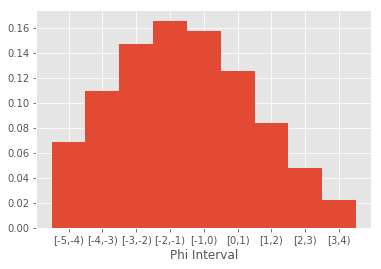

In [22]:
phi_steps = get_phi_steps(config["MIN_GRAINSIZE"], config["MAX_GRAINSIZE"], 
                          config["PART_STEPS"], 
                          config["MEDIAN_GRAINSIZE"], config["STD_GRAINSIZE"],
                          globs["LITHIC_DIAMETER_THRESHOLD"], 
                          globs["PUMICE_DIAMETER_THRESHOLD"], 
                          config["LITHIC_DENSITY"], config["PUMICE_DENSITY"])
step_width = (config["MAX_GRAINSIZE"] - config["MIN_GRAINSIZE"])/config["PART_STEPS"]

display(pd.DataFrame(phi_steps))



probs = [phi["probability"] for phi in phi_steps]
x = [phi["centroid"] for phi in phi_steps]
labels = [phi["interval"] for phi in phi_steps]
fig, ax = plt.subplots()
ax.bar(x, probs, width=1, align="center")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel("Phi Interval")
plt.show()

In [26]:
t = process_time()
t_tot = process_time()
df_list = []

q_dist = beta(config["ALPHA"],config["BETA"])

grid = obs_df[["Easting", "Northing"]]
wind_angle = np.radians(55)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
for phi_step in phi_steps:
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    input_table, gsm_df, sig, vv, tft= gaussian_stack_single_phi(
        grid, 20, config["VENT_ELEVATION"], 
        config["PLUME_HEIGHT"], 
        (config["ALPHA"], config["BETA"]),
        mass_in_phi, (u,v), 
        phi_step["lower"], phi_step["density"], 2500,
        config["DIFFUSION_COEFFICIENT"],
        config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"])
    df_list.append(gsm_df.rename(columns={"MassArea":phi_step["interval"]}))


elapsed_time = process_time() - t
print("Forward Sim time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge = reduce(lambda x, y: pd.merge(x, y, on =['Northing', 'Easting']), df_list)
elapsed_time = process_time() - t
print("Dataframe Merge time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge["MassArea"] = np.sum(df_merge[labels], 1)
elapsed_time = process_time() - t
print("Tot M/A calc time: %.5f seconds"%elapsed_time)

t = process_time()
for label in labels:
    df_merge[label] = df_merge.apply(lambda row: (row[label]/row["MassArea"])*100, axis=1) # This operation is much faster

elapsed_time = process_time() - t
print("Phi Wt perc calc time: %.5f seconds"%elapsed_time)

total_time = process_time() - t_tot
print("Total time: %.5f seconds"%total_time)

forward_df = df_merge

# forward_df["MassArea"] = forward_df["MassArea"]*(6991/9469)

forward_df["radius"] = np.sqrt(forward_df["Easting"]**2 + forward_df["Northing"]**2)
forward_df = forward_df.sort_values(by=['radius'])
forward_df["Residual"] = forward_df["MassArea"].values/obs_df["MassArea"].values
display(forward_df.head())

Forward Sim time: 0.01562 seconds
Dataframe Merge time: 0.01562 seconds
Tot M/A calc time: 0.01562 seconds
Phi Wt perc calc time: 0.01562 seconds
Total time: 0.06250 seconds


,Northing,Easting,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",MassArea,radius,Residual
0,1506,1499,17.0237,24.0587,24.7461,19.0106,10.9865,3.68062,0.476505,0.0172657,3.63504e-05,"1,316.8","2,124.86",2.10419
1,1997,1957,13.849,22.1879,24.803,20.3647,12.8847,5.06294,0.813217,0.0344694,8.0275e-05,"1,148.99","2,796.04",2.75405
2,2173,1787,13.8004,22.2099,24.865,20.38,12.8556,5.04311,0.811521,0.0345019,8.06424e-05,"1,166.99","2,813.41",2.33099
3,3082,-770,15.5611,23.6747,24.9019,19.0596,11.4484,4.52251,0.794749,0.0368917,9.33995e-05,300.905,"3,176.73",0.506139
4,3152,-1673,16.2556,24.3211,24.9428,18.4296,10.7682,4.36764,0.869463,0.0453801,0.000126158,111.015,"3,568.48",0.886983


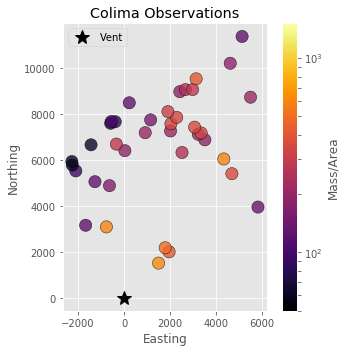

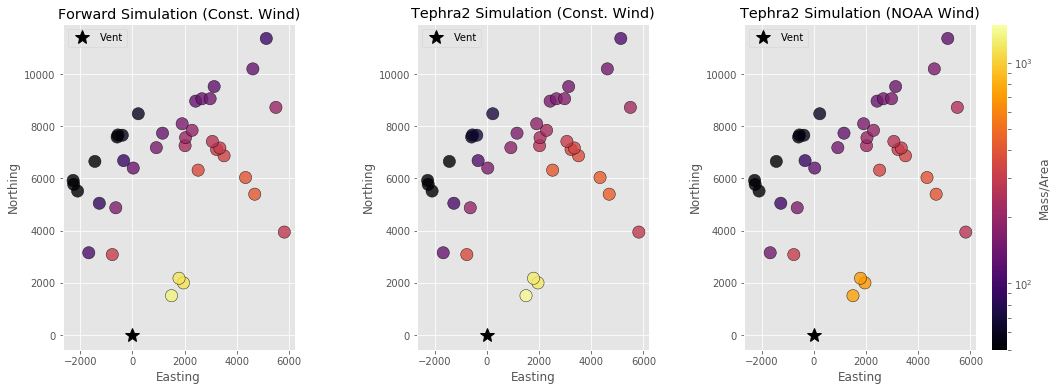

In [27]:

fig, ax = plt.subplots(1, 1, figsize=(5,5))

vis.plot_sample(obs_df, vent=(0,0), log=True, bounds=(50, 1500),
            title="Colima Observations", cbar_label="Mass/Area", ax = ax)
plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1, 3, figsize=(
        18,6), facecolor='w', edgecolor='k')
axs = axs.ravel()

vis.plot_sample(forward_df, vent=(0,0), log=True, bounds=(50, 1500), show_cbar=False,
            title="Forward Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[0])
vis.plot_sample(t2_const_df, vent=(0,0), log=True, bounds=(50, 1500), show_cbar=False,
            title="Tephra2 Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[1])
vis.plot_sample(t2_df, vent=(0,0), log=True, bounds=(50, 1500),
            title="Tephra2 Simulation (NOAA Wind)", cbar_label="Mass/Area", ax=axs[2])
plt.show()




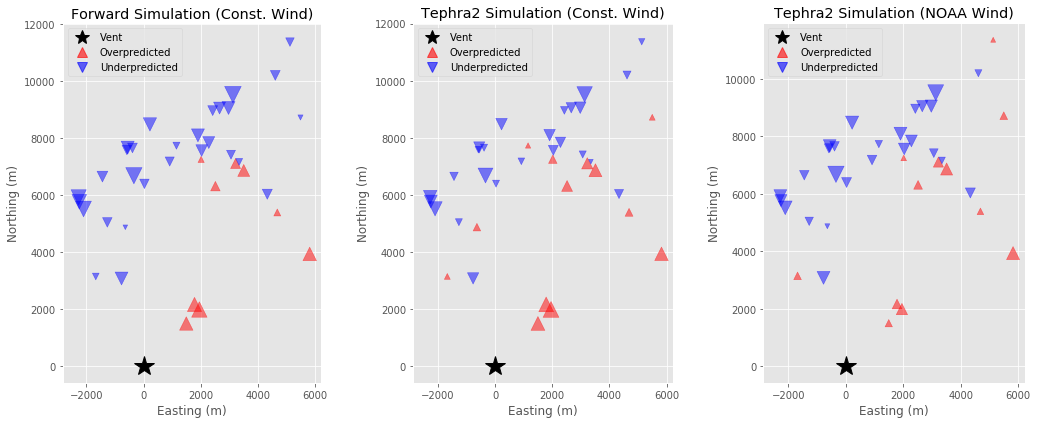

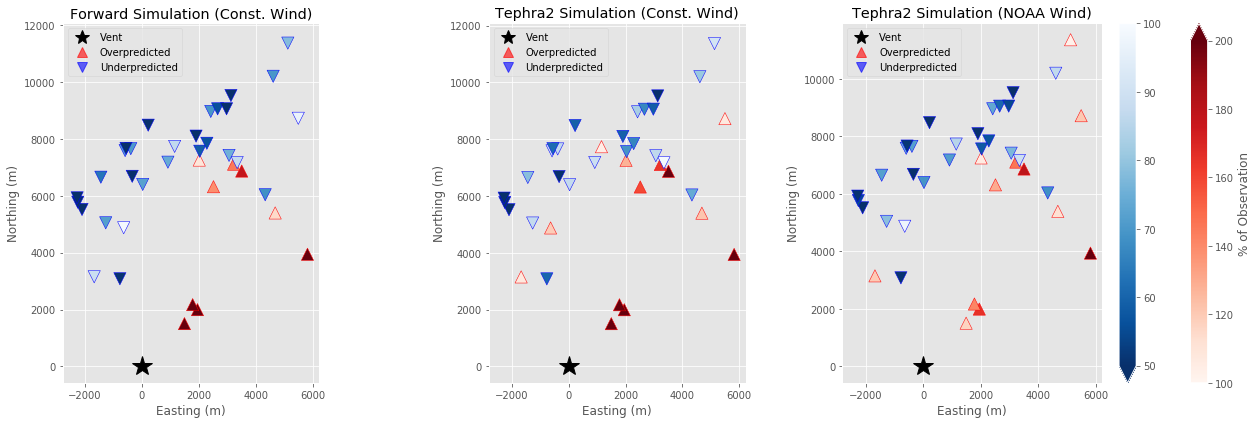

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(
        15,6), facecolor='w', edgecolor='k')
axs = axs.ravel()


vis.plot_residuals(forward_df, vent=(0,0), values="Residual",
            title="Forward Simulation (Const. Wind)", 
            plot_type = "size", ax=axs[0])
vis.plot_residuals(t2_const_df, vent=(0,0), values="Residual",
            title="Tephra2 Simulation (Const. Wind)", 
             plot_type = "size", ax=axs[1])
vis.plot_residuals(t2_df, vent=(0,0), values="Residual",
            title="Tephra2 Simulation (NOAA Wind)", 
             plot_type = "size", ax=axs[2])


plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(
        18,6), facecolor='w', edgecolor='k')
axs = axs.ravel()


vis.plot_residuals(forward_df, vent=(0,0), values="Residual",
            title="Forward Simulation (Const. Wind)", 
            plot_type = "cmap", ax=axs[0], show_cbar = False)
vis.plot_residuals(t2_const_df, vent=(0,0), values="Residual",
            title="Tephra2 Simulation (Const. Wind)", 
             plot_type = "cmap", ax=axs[1], show_cbar = False)
vis.plot_residuals(t2_df, vent=(0,0), values="Residual",
            title="Tephra2 Simulation (NOAA Wind)", 
             plot_type = "cmap", ax=axs[2], show_cbar = True)


# plt.tight_layout()
plt.show()

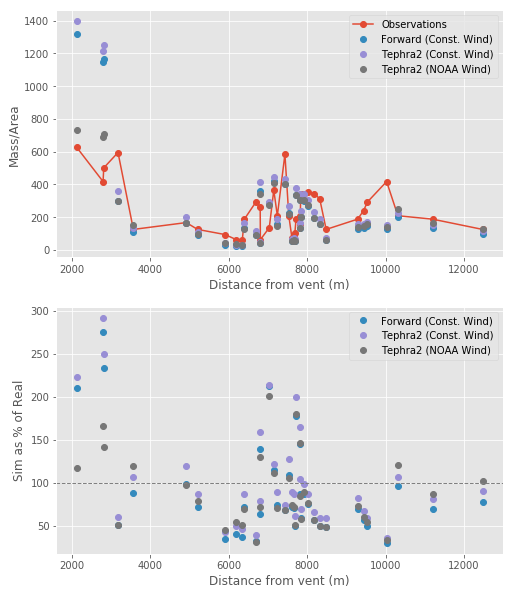

In [34]:
fig, axs = plt.subplots(2,1, figsize=(
        8,10), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C0o-', label="Observations")
# plt.plot(rotdf["radius"].values, rotdf["MassArea"].values, 'C1o-')
axs[0].plot(forward_df["radius"].values, forward_df["MassArea"].values, 'C1o', label="Forward (Const. Wind)")
axs[0].plot(t2_const_df["radius"].values, t2_const_df["MassArea"].values, 'C2o', label="Tephra2 (Const. Wind)")
axs[0].plot(t2_df["radius"].values, t2_df["MassArea"].values, 'C3o', label="Tephra2 (NOAA Wind)")
axs[0].legend()
axs[0].set_xlabel("Distance from vent (m)")
axs[0].set_ylabel("Mass/Area")

axs[1].plot(forward_df["radius"].values, forward_df["Residual"].values*100, 'C1o', label="Forward (Const. Wind)")
axs[1].plot(t2_const_df["radius"].values, t2_const_df["Residual"].values*100, 'C2o', label="Tephra2 (Const. Wind)")
axs[1].plot(t2_df["radius"].values, t2_df["Residual"].values*100, 'C3o', label="Tephra2 (NOAA Wind)")
axs[1].axhline(100, linestyle="--", lw=1, c="gray")
axs[1].legend()
axs[1].set_xlabel("Distance from vent (m)")
axs[1].set_ylabel("Sim as % of Real")
plt.show()

========Const. Wind Simulation========
a* = -4.47831	b* = -0.34722            	h1* = 1.85307
a = 1.01135	b = 1.70665	h1 = 25647.39742
Success: True, Optimization terminated successfully.
Iterations: 102
SSE: 2.561996235406539


,Height,Suspended Mass
0,"4,430.75",5.5447e+09
1,"5,776.5",5.33562e+09
2,"7,122.25",5.10109e+09
3,"8,468",4.85217e+09
4,"9,813.75",4.592e+09
5,"11,159.5",4.32157e+09
6,"12,505.2",4.04094e+09
7,"13,851",3.74962e+09
8,"15,196.8",3.44662e+09
9,"16,542.5",3.13046e+09


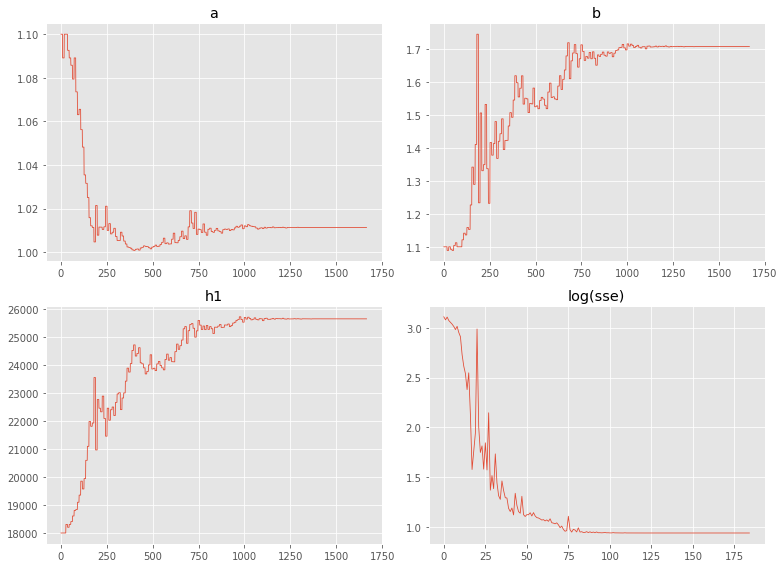

========T2 Const. Wind Simulation========
a* = -3.88271	b* = -1.07318            	h1* = 0.98076
a = 1.02060	b = 1.34192	h1 = 20618.15542
Success: True, Optimization terminated successfully.
Iterations: 96
SSE: 18.416121095673986


,Height,Suspended Mass
0,"4,430.75",5.62815e+09
1,"5,776.5",5.54213e+09
2,"7,122.25",5.4099e+09
3,"8,468",5.25005e+09
4,"9,813.75",5.06674e+09
5,"11,159.5",4.85966e+09
6,"12,505.2",4.62589e+09
7,"13,851",4.3597e+09
8,"15,196.8",4.05121e+09
9,"16,542.5",3.68264e+09


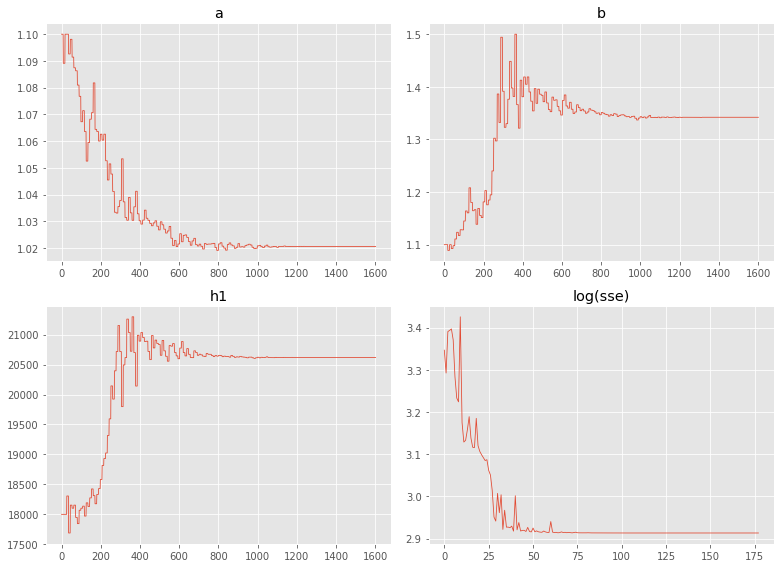

========T2 NOAA Wind Simulation========
a* = -2.21347	b* = -2.32997            	h1* = 2.55045
a = 1.10932	b = 1.09730	h1 = 27747.64901
Success: True, Optimization terminated successfully.
Iterations: 105
SSE: 240.30826205132416


,Height,Suspended Mass
0,"4,430.75",2.69256e+09
1,"5,776.5",2.88777e+09
2,"7,122.25",3.00014e+09
3,"8,468",3.07573e+09
4,"9,813.75",3.12958e+09
5,"11,159.5",3.16844e+09
6,"12,505.2",3.19587e+09
7,"13,851",3.21383e+09
8,"15,196.8",3.22337e+09
9,"16,542.5",3.22493e+09


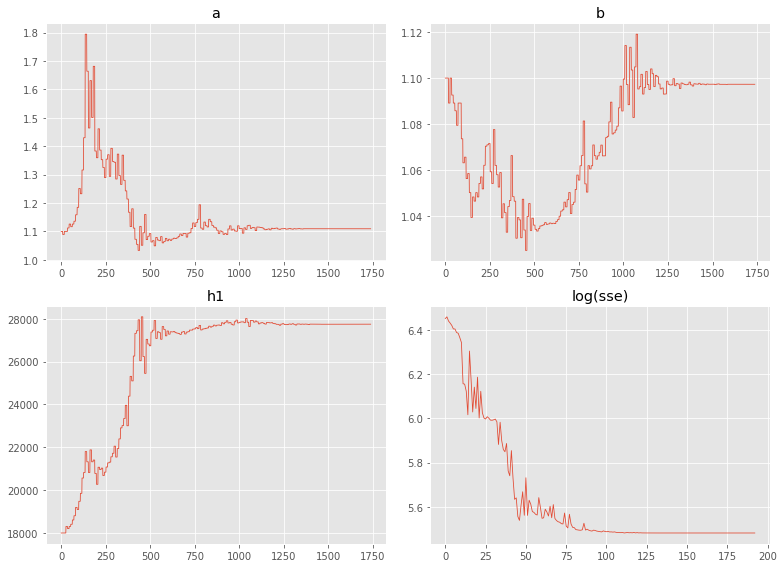

========Observation Data========
a* = -3.64549	b* = 0.65955            	h1* = 2.21748
a = 1.02611	b = 2.93393	h1 = 26905.06227
Success: True, Optimization terminated successfully.
Iterations: 92
SSE: 2720.158139096673


,Height,Suspended Mass
0,"4,430.75",8.56717e+09
1,"5,776.5",7.74168e+09
2,"7,122.25",6.88902e+09
3,"8,468",6.05687e+09
4,"9,813.75",5.26163e+09
5,"11,159.5",4.51135e+09
6,"12,505.2",3.81079e+09
7,"13,851",3.16317e+09
8,"15,196.8",2.57085e+09
9,"16,542.5",2.03573e+09


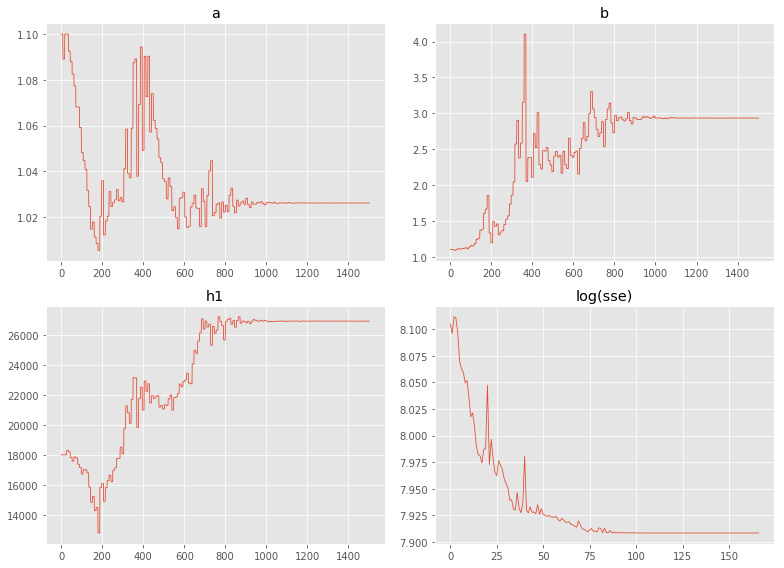

In [35]:
priors_vals = {
    "a": 1.1,
    "b": 1.1,
    "h1": 18000,
    "u": u,
    "v": v,
    "D": config["DIFFUSION_COEFFICIENT"],
    "ftt": config["FALL_TIME_THRESHOLD"],
    "M": config["ERUPTION_MASS"]
}

invert_params = {
    "a" : True,
    "b" : True,
    "h1" : True,
    "u": False,
    "v": False,
    "D": False,
    "ftt": False,
    "M": False
}

H = 30000

wind_angle = np.radians(55.5)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
names = ["Const. Wind Simulation", "T2 Const. Wind Simulation","T2 NOAA Wind Simulation", "Observation Data"]
data_sets = [forward_df, t2_const_df, t2_df, obs_df]
inverted_masses_list = []
params_list = []
for name, df in zip(names, data_sets):
    print("========%s========"%name)
    out = gaussian_stack_plume_inversion(
        df, len(df), 20, 
        config["VENT_ELEVATION"], H, 2500,
        phi_steps, config["EDDY_CONST"],
        invert_params=invert_params,
        priors = priors_vals, 
        column_cap=H)
    inversion_table, params, sol, sse, trace, _, sse_trace = out
    
    inv_mass = inversion_table["Suspended Mass"].values
    inverted_masses_list += [inv_mass]
    params_list += [params]
    display(inversion_table)
    trace = np.array(trace)
    fig, axs = plt.subplots(2,2, figsize=(
            11, 8), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(trace[:,2], linewidth=.8)
    axs[2].set_title("h1")

    axs[3].plot(np.log(sse_trace), linewidth=.8)
    axs[3].set_title("log(sse)")

    plt.tight_layout()
    plt.show()



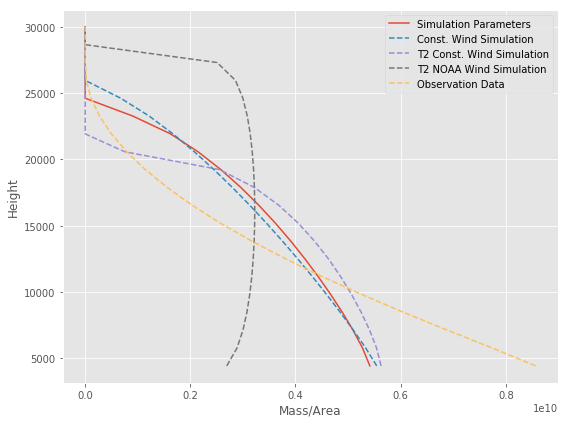

In [36]:
fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            inversion_table["Height"],
            config["ERUPTION_MASS"])

ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
for name, mass in zip(names, inverted_masses_list):
    ax1.plot(mass, 
         inversion_table["Height"], 
         '--', label=name)
ax1.legend()
# ax1.set_title("Mass in Column as inverted from various datasets")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()


========Const. Wind Simulation========


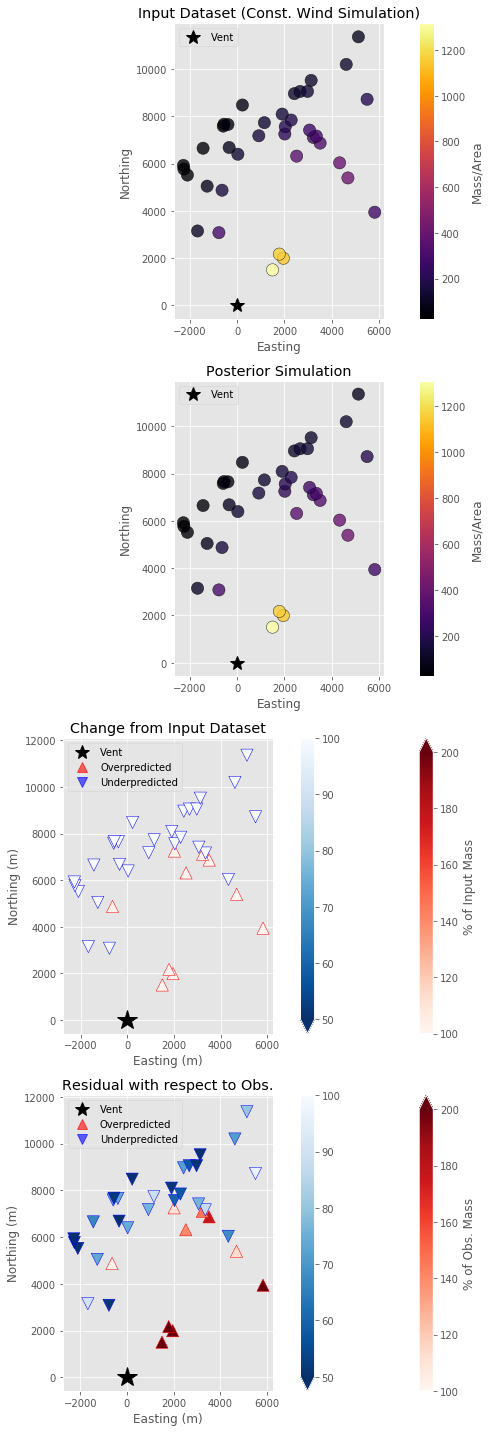

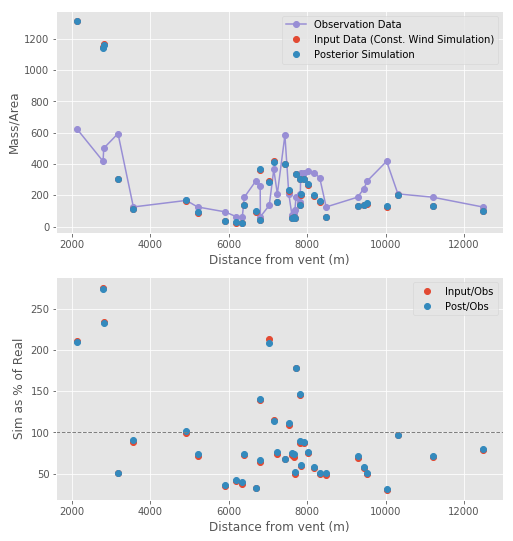

========T2 Const. Wind Simulation========


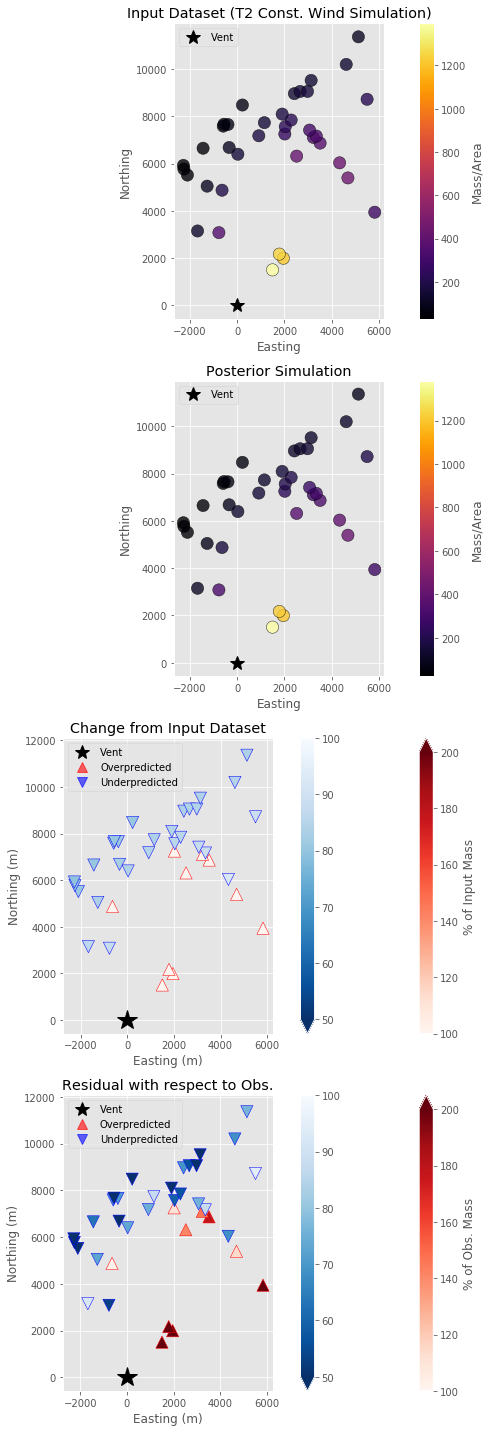

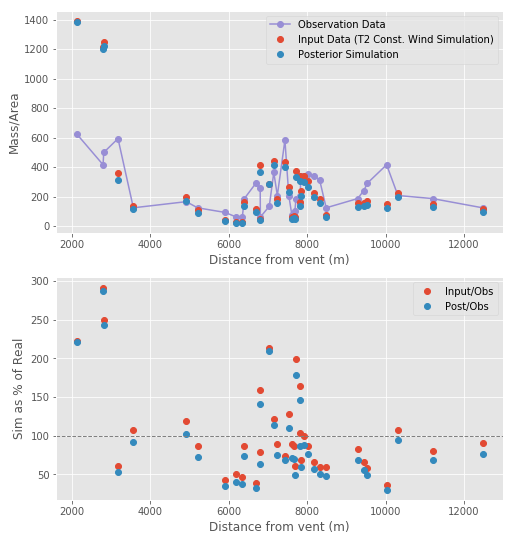

========T2 NOAA Wind Simulation========


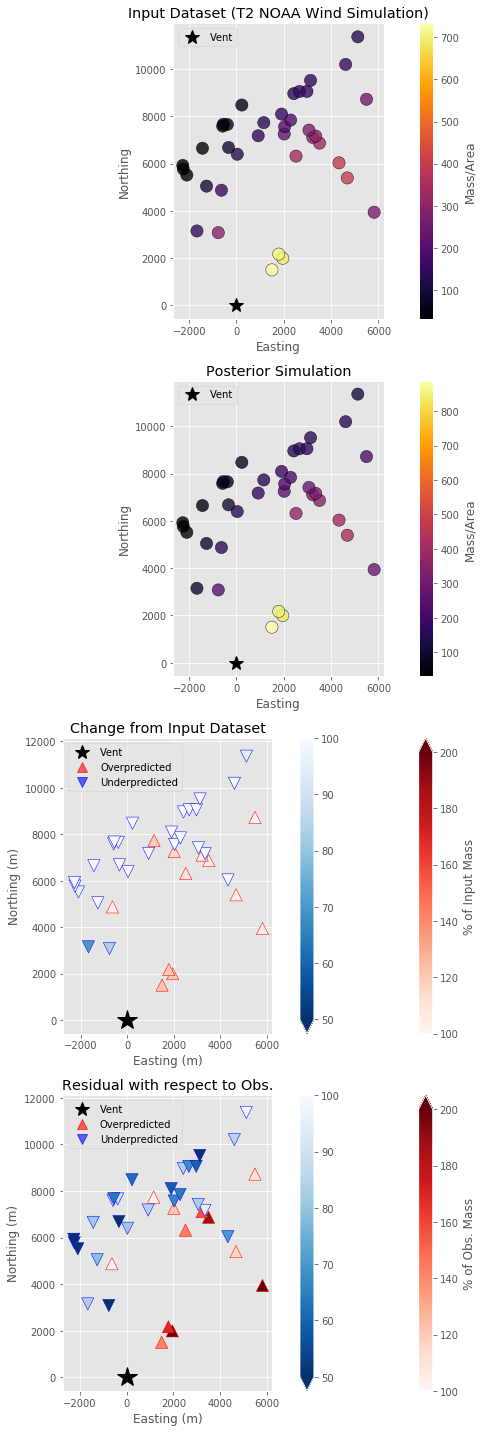

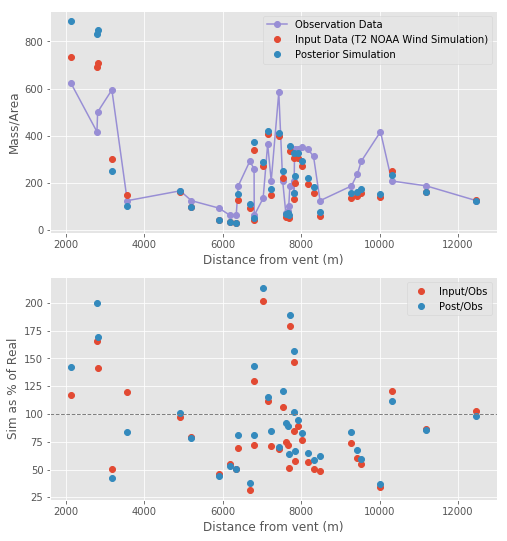

========Observation Data========


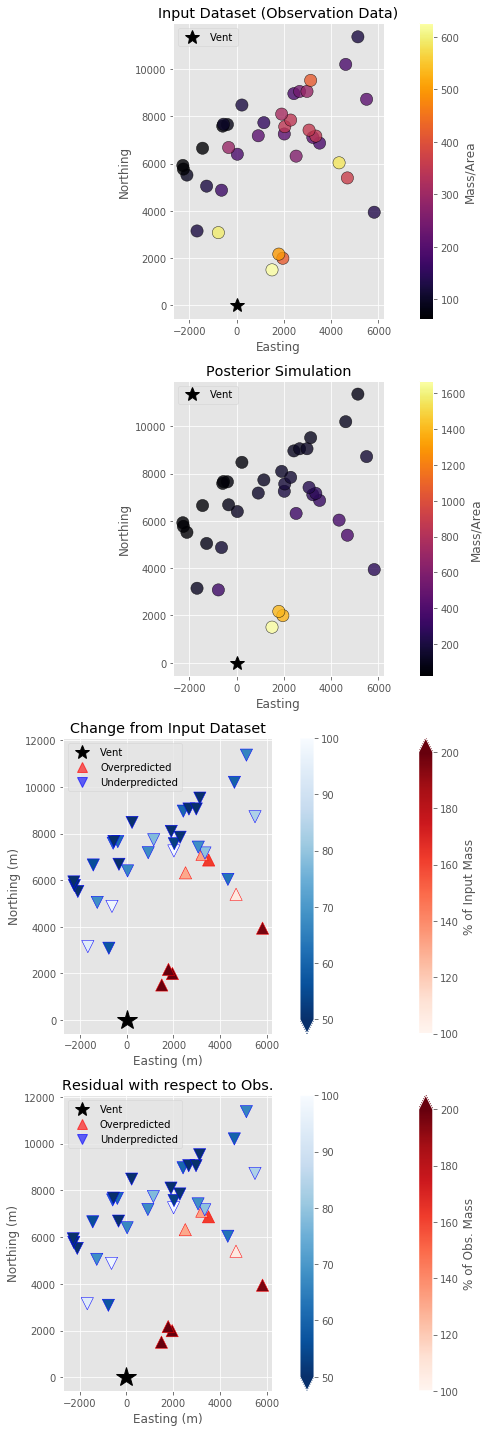

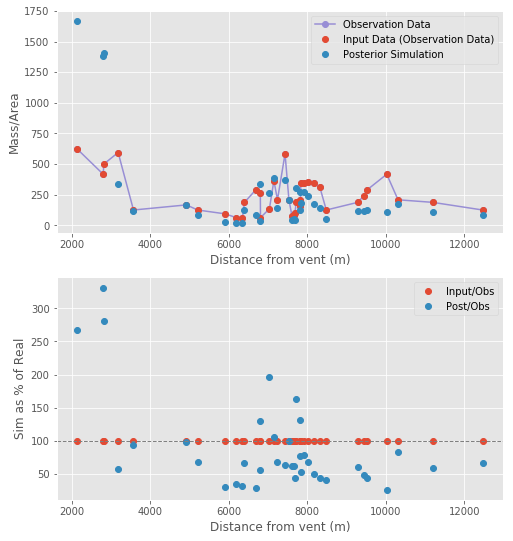

In [40]:
# for name, params, mass, in_data in zip(names, params_list, inverted_masses_list, data_sets):
#     print("========%s========"%name)
#     q_dist = beta(params["a"],params["b"])

#     grid = obs_df[["Easting", "Northing"]]

#     post_df = gaussian_stack_forward(
#         grid, int(config["COL_STEPS"]), config["VENT_ELEVATION"], 
#         params["h1"], 2500, phi_steps, (params["a"],params["b"]), config["ERUPTION_MASS"], 
#         (u,v), config["DIFFUSION_COEFFICIENT"], config["EDDY_CONST"],
#         config["FALL_TIME_THRESHOLD"]
#     )
    
#     post_df["radius"] = np.sqrt(post_df["Easting"]**2 + post_df["Northing"]**2)
#     post_df = post_df.sort_values(by=['radius'])
#     post_df["Residual"] = post_df["MassArea"].values/obs_df["MassArea"].values*100
#     post_df["Change"] = post_df["MassArea"].values/in_data["MassArea"].values*100
    
#     fig, axs = plt.subplots(4,1, figsize=(
#             10, 20), facecolor='w', edgecolor='k')
#     axs = axs.ravel()
    
#     vis.plot_sample(in_data, vent=(0,0), log=False, 
#                 title="Input Dataset (%s)"%name, cbar_label="Mass/Area", ax=axs[0])
#     vis.plot_sample(post_df, vent=(0,0), log=False, 
#                 title="Posterior Simulation", cbar_label="Mass/Area", ax=axs[1])
#     vis.plot_sample(post_df, vent=(0,0), log=True, values="Change",
#                 title="Input Data Residual", cbar_label="log(Residual) (% of Input Mass)", ax=axs[2])
#     vis.plot_sample(post_df, vent=(0,0), log=True, values="Residual",
#                 title="Observation Data Residual", cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[3])

#     plt.tight_layout()
#     plt.show()

    
#     fig, axs = plt.subplots(2,1, figsize=(
#             8, 9), facecolor='w', edgecolor='k')
#     axs = axs.ravel()

#     axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C2o-', label="Observation Data")
#     axs[0].plot(in_data["radius"].values, in_data["MassArea"].values, 'C0o', label="Input Data (%s)"%name)
#     axs[0].plot(post_df["radius"].values, post_df["MassArea"].values, 'C1o', label="Posterior Simulation")
#     axs[0].legend()
#     axs[0].set_xlabel("Distance from vent (m)")
#     axs[0].set_ylabel("Mass/Area")


#     axs[1].plot(in_data["radius"].values, in_data["Residual"].values, 'C0o', label="Input/Obs")
#     axs[1].plot(post_df["radius"].values, post_df["Residual"].values, 'C1o', label="Post/Obs")
#     axs[1].axhline(100, linestyle="--", lw=1, c="gray")
#     axs[1].legend()
#     axs[1].set_xlabel("Distance from vent (m)")
#     axs[1].set_ylabel("Sim as % of Real")
#     plt.show()
    
for name, params, mass, in_data in zip(names, params_list, inverted_masses_list, data_sets):
    print("========%s========"%name)
    q_dist = beta(params["a"],params["b"])

    grid = obs_df[["Easting", "Northing"]]

    post_df = gaussian_stack_forward(
        grid, int(config["COL_STEPS"]), config["VENT_ELEVATION"], 
        params["h1"], 2500, phi_steps, (params["a"],params["b"]), config["ERUPTION_MASS"], 
        (u,v), config["DIFFUSION_COEFFICIENT"], config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"]
    )
    
    post_df["radius"] = np.sqrt(post_df["Easting"]**2 + post_df["Northing"]**2)
    post_df = post_df.sort_values(by=['radius'])
    post_df["Residual"] = post_df["MassArea"].values/obs_df["MassArea"].values
    post_df["Change"] = post_df["MassArea"].values/in_data["MassArea"].values
    
    fig, axs = plt.subplots(4,1, figsize=(
            10, 20), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    
    vis.plot_sample(in_data, vent=(0,0), log=False, 
                title="Input Dataset (%s)"%name, cbar_label="Mass/Area", ax=axs[0])
    vis.plot_sample(post_df, vent=(0,0), log=False, 
                title="Posterior Simulation", cbar_label="Mass/Area", ax=axs[1])
    vis.plot_residuals(post_df, vent=(0,0), values="Change", plot_type="cmap",
                title="Change from Input Dataset", cbar_label="% of Input Mass", ax=axs[2])
    vis.plot_residuals(post_df, vent=(0,0), values="Residual", plot_type="cmap",
                title="Residual with respect to Obs.", cbar_label="% of Obs. Mass", ax=axs[3])

    plt.tight_layout()
    plt.show()

    
    fig, axs = plt.subplots(2,1, figsize=(
            8, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C2o-', label="Observation Data")
    axs[0].plot(in_data["radius"].values, in_data["MassArea"].values, 'C0o', label="Input Data (%s)"%name)
    axs[0].plot(post_df["radius"].values, post_df["MassArea"].values, 'C1o', label="Posterior Simulation")
    axs[0].legend()
    axs[0].set_xlabel("Distance from vent (m)")
    axs[0].set_ylabel("Mass/Area")


    axs[1].plot(in_data["radius"].values, in_data["Residual"].values*100, 'C0o', label="Input/Obs")
    axs[1].plot(post_df["radius"].values, post_df["Residual"].values*100, 'C1o', label="Post/Obs")
    axs[1].axhline(100, linestyle="--", lw=1, c="gray")
    axs[1].legend()
    axs[1].set_xlabel("Distance from vent (m)")
    axs[1].set_ylabel("Sim as % of Real")
    plt.show()

========Const. Wind Simulation========
a* = 0.00598	b* = 1.44088	            h1* = 5.36825	u* = 1.78889	v* = 2.07350	            D* = 8.48992	ftt* = 7.85404	TM* = 24.73060
a = 2.00600	b = 5.22439	            h1 = 29860.45705	u = 5.98278	v = 7.95258	            D = 4865.47523	ftt = 2576.11878	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 917
SSE: 43.05246868860251


,Height,Suspended Mass
0,"4,430.75",3.62517e+09
1,"5,776.5",5.78646e+09
2,"7,122.25",6.82451e+09
3,"8,468",7.04421e+09
4,"9,813.75",6.70072e+09
5,"11,159.5",6.00191e+09
6,"12,505.2",5.11239e+09
7,"13,851",4.15801e+09
8,"15,196.8",3.2304e+09
9,"16,542.5",2.39157e+09


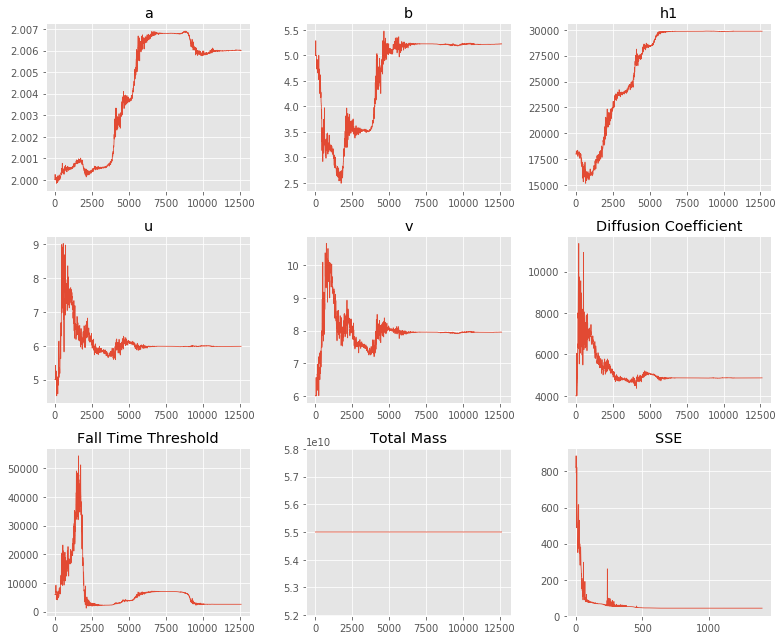

Const. Wind Simulation Run Time: 2.19010 minutes


========T2 Const. Wind Simulation========
a* = 0.05725	b* = 1.46579	            h1* = 2.81067	u* = 1.71832	v* = 2.15434	            D* = 8.43332	ftt* = 7.84418	TM* = 24.73060
a = 2.05892	b = 5.33098	            h1 = 28248.28041	u = 5.57517	v = 8.62223	            D = 4597.71933	ftt = 2550.83763	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 910
SSE: 56.79260158974032


,Height,Suspended Mass
0,"4,430.75",3.8689e+09
1,"5,776.5",6.26551e+09
2,"7,122.25",7.36661e+09
3,"8,468",7.51216e+09
4,"9,813.75",7.01222e+09
5,"11,159.5",6.12522e+09
6,"12,505.2",5.05512e+09
7,"13,851",3.95425e+09
8,"15,196.8",2.92852e+09
9,"16,542.5",2.04369e+09


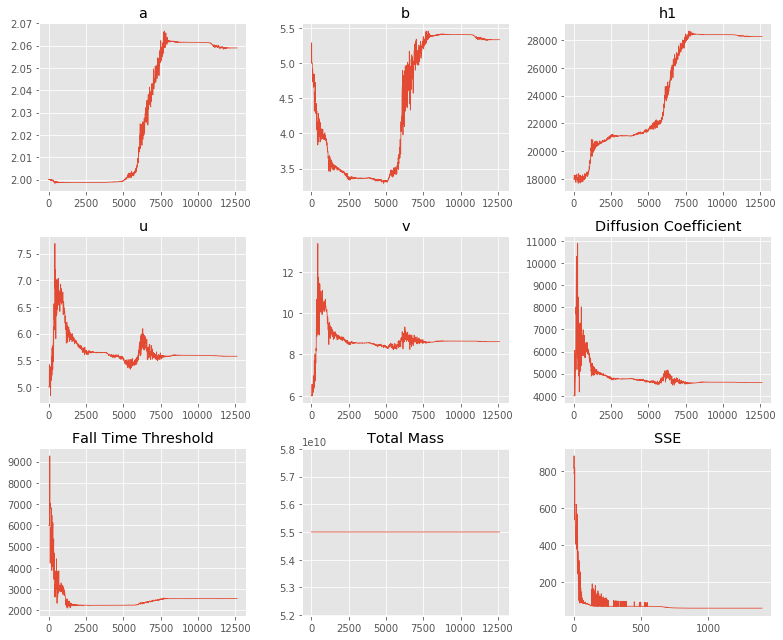

T2 Const. Wind Simulation Run Time: 2.29453 minutes


========T2 NOAA Wind Simulation========
a* = -0.01318	b* = 1.14697	            h1* = 5.20069	u* = 1.91776	v* = 2.08229	            D* = 9.06243	ftt* = 17.85810	TM* = 24.73060
a = 1.98691	b = 4.14863	            h1 = 29835.07213	u = 6.80570	v = 8.02284	            D = 8625.11201	ftt = 56973810.50977	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 925
SSE: 224.78046866573274


,Height,Suspended Mass
0,"4,430.75",2.59562e+09
1,"5,776.5",4.33415e+09
2,"7,122.25",5.39483e+09
3,"8,468",5.91234e+09
4,"9,813.75",6.00406e+09
5,"11,159.5",5.77353e+09
6,"12,505.2",5.31184e+09
7,"13,851",4.69828e+09
8,"15,196.8",4.00089e+09
9,"16,542.5",3.27675e+09


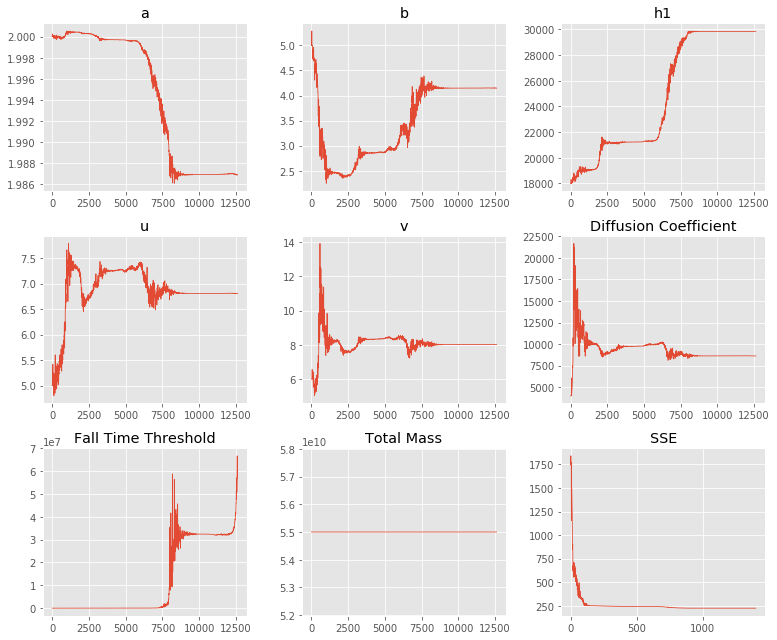

T2 NOAA Wind Simulation Run Time: 2.30130 minutes


========Observation Data========
a* = -0.00083	b* = 0.11108	            h1* = 1.50100	u* = 0.73871	v* = 1.61044	            D* = 9.01368	ftt* = 9.04222	TM* = 24.73060
a = 1.99917	b = 2.11748	            h1 = 24005.65085	u = 2.09324	v = 5.00504	            D = 8214.71724	ftt = 8452.55252	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 667
SSE: 810.3846984430005


,Height,Suspended Mass
0,"4,430.75",1.39912e+09
1,"5,776.5",2.58267e+09
2,"7,122.25",3.55463e+09
3,"8,468",4.31835e+09
4,"9,813.75",4.87731e+09
5,"11,159.5",5.23534e+09
6,"12,505.2",5.39672e+09
7,"13,851",5.36632e+09
8,"15,196.8",5.14979e+09
9,"16,542.5",4.75391e+09


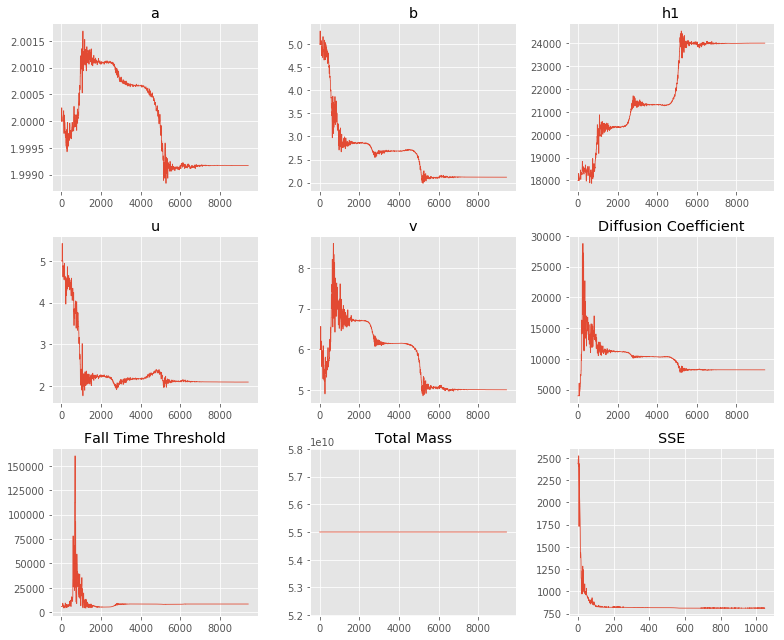

Observation Data Run Time: 1.70573 minutes


Total Run Time: 8.49167 minutes


In [42]:
priors_vals = {
    "a": 2,
    "b": 5,
    "h1": 18000,
    "u": 5,
    "v": 6,
    "D": 4000,
    "ftt": 6000,
    "M": config["ERUPTION_MASS"]
}

invert_params = {
    "a" : True,
    "b" : True,
    "h1" : True,
    "u": True,
    "v": True,
    "D": True,
    "ftt": True,
    "M": False
}

H = 30000

t_tot = process_time()
single_run_time = 0
wind_angle = np.radians(55.5)

names = ["Const. Wind Simulation", 
         "T2 Const. Wind Simulation",
         "T2 NOAA Wind Simulation", 
         "Observation Data"]
data_sets = [forward_df, t2_const_df, t2_df, obs_df]

inverted_masses_list = []
params_list = []
for name, df in zip(names, data_sets):
    t = process_time()
    
    print("========%s========"%name)
    out = gaussian_stack_inversion(
        df, len(df), 20, config["VENT_ELEVATION"], 
        H, 2500, phi_steps,
        invert_params=invert_params,
        priors=priors_vals,
        column_cap=H)
    inversion_table, params, sol, sse, plume_trace, param_trace, sse_trace = out
    inv_mass = inversion_table["Suspended Mass"].values
    inverted_masses_list += [inv_mass]
    params_list += [params]
    display(inversion_table)
    plume_trace = np.array(plume_trace)
    param_trace = np.array(param_trace)
    fig, axs = plt.subplots(3,3, figsize=(
            11, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(plume_trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(plume_trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(plume_trace[:,2], linewidth=.8)
    axs[2].set_title("h1")
    
    axs[3].plot(param_trace[:,0], linewidth=.8)
    axs[3].set_title("u")

    axs[4].plot(param_trace[:,1], linewidth=.8)
    axs[4].set_title("v")
    
    axs[5].plot(param_trace[:,2], linewidth=.8)
    axs[5].set_title("Diffusion Coefficient")
    
    axs[6].plot(param_trace[:,3], linewidth=.8)
    axs[6].set_title("Fall Time Threshold")
    
    axs[7].plot(param_trace[:,4], linewidth=.8)
    axs[7].set_title("Total Mass")

    axs[8].plot(sse_trace, linewidth=.8)
    axs[8].set_title("SSE")

    plt.tight_layout()
    # plt.savefig("colima/real_trace.png", dpi=200, format='png')
    plt.show()
    
    run_time = process_time() - t
    print("%s Run Time: %.5f minutes\n\n"%(name, run_time/60))


total_run_time = process_time() - t_tot

print("Total Run Time: %.5f minutes"%(total_run_time/60))

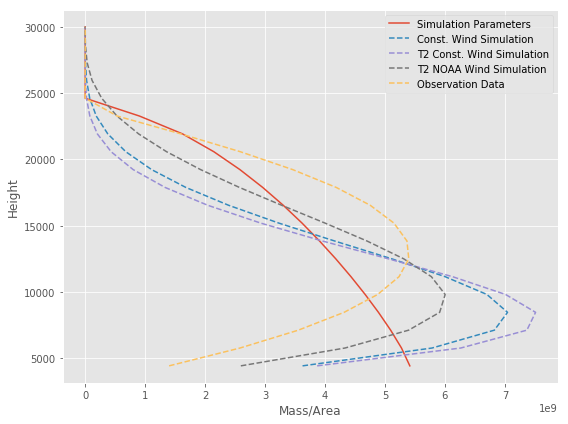

,Dataset,a,b,h1,u,v,D,ftt,M
0,Const. Wind Simulation,2.006,5.22439,"29,860.5",5.98278,7.95258,"4,865.48","2,576.12",5.5e+10
1,T2 Const. Wind Simulation,2.05892,5.33098,"28,248.3",5.57517,8.62223,"4,597.72","2,550.84",5.5e+10
2,T2 NOAA Wind Simulation,1.98691,4.14863,"29,835.1",6.8057,8.02284,"8,625.11",5.69738e+07,5.5e+10
3,Observation Data,1.99917,2.11748,"24,005.7",2.09324,5.00504,"8,214.72","8,452.55",5.5e+10


In [44]:
fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

q_dist = beta(config["ALPHA"],config["BETA"])

q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            inversion_table["Height"],
            config["ERUPTION_MASS"])

ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
for name, mass in zip(names, inverted_masses_list):
    ax1.plot(mass, 
         inversion_table["Height"], 
         '--', label=name)
ax1.legend()
# ax1.set_title("Mass in Column as inverted from various datasets")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()
params_df = pd.DataFrame(params_list)
params_df["Dataset"] = names
params_df = params_df[["Dataset", "a", "b", "h1", "u", "v", "D", "ftt", "M"]]
display(params_df)

========Const. Wind Simulation========


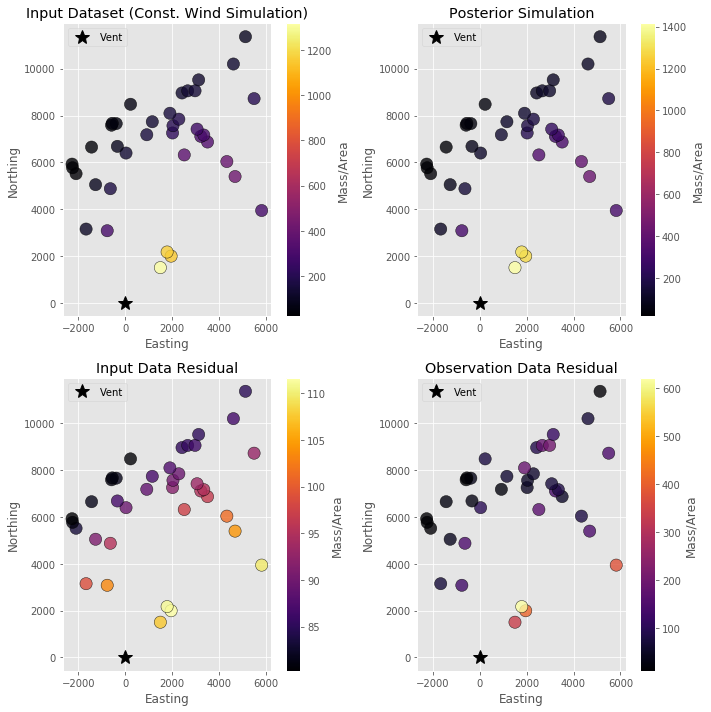

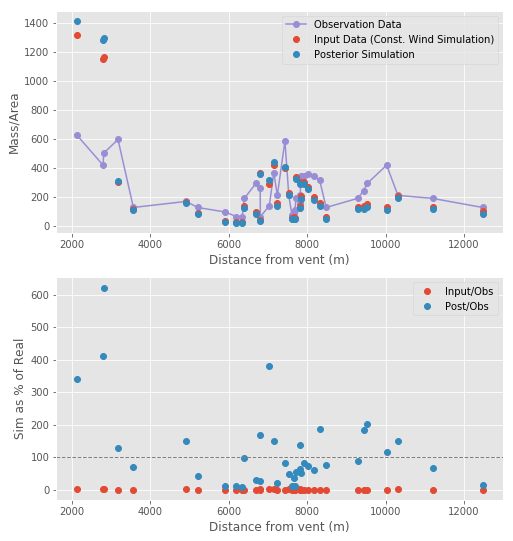

========T2 Const. Wind Simulation========


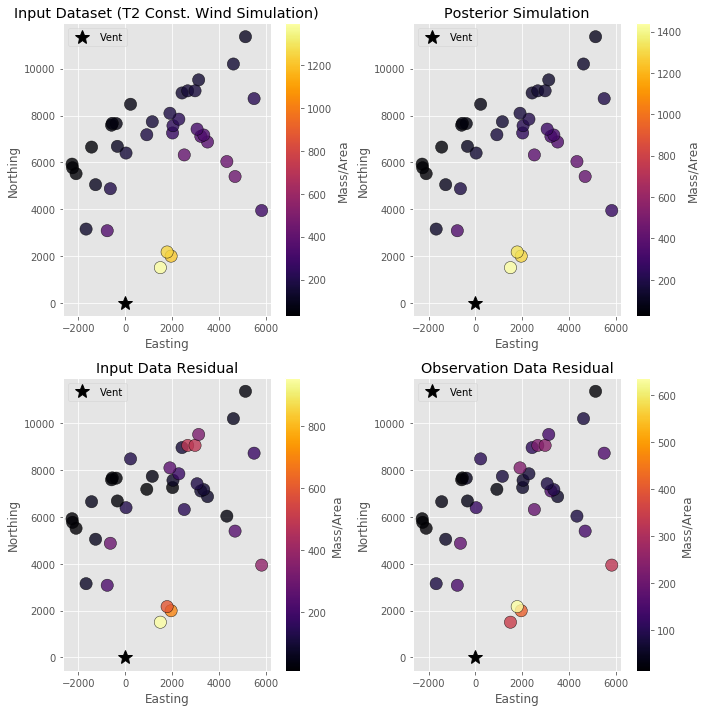

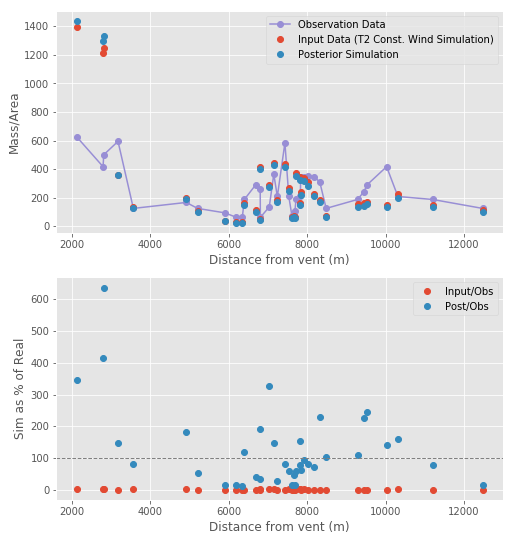

========T2 NOAA Wind Simulation========


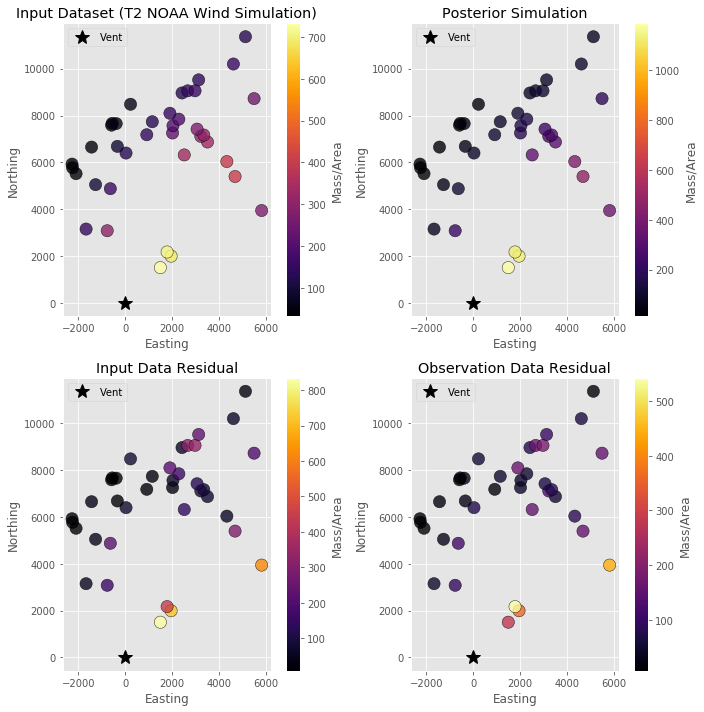

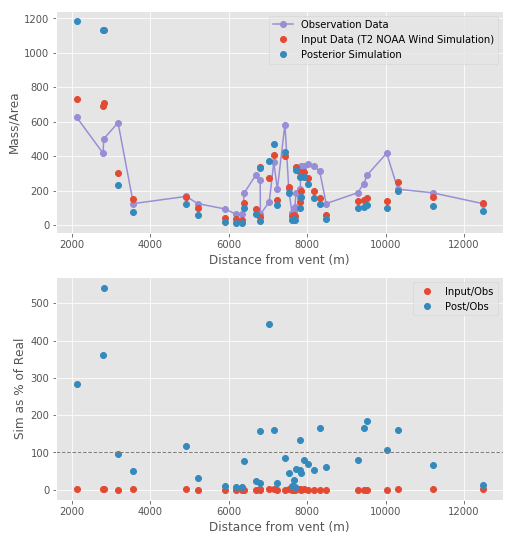

========Observation Data========


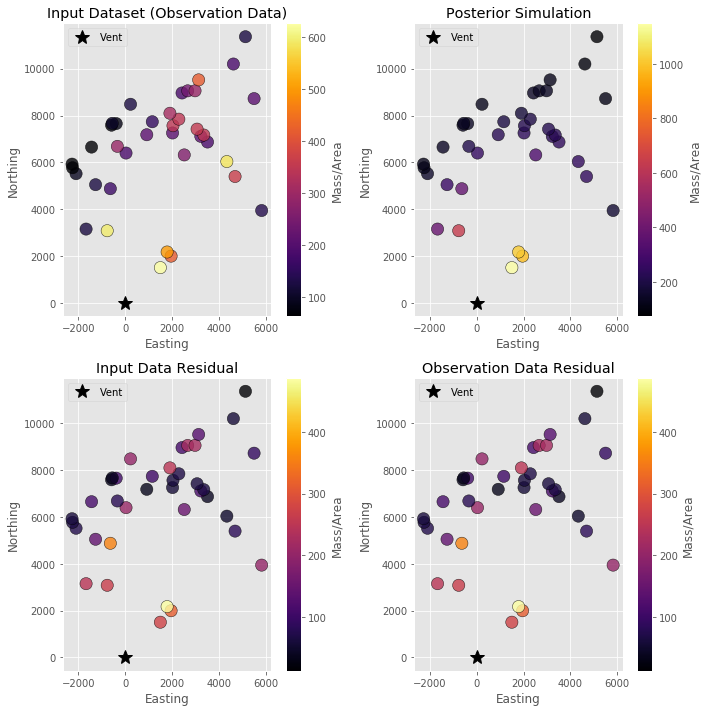

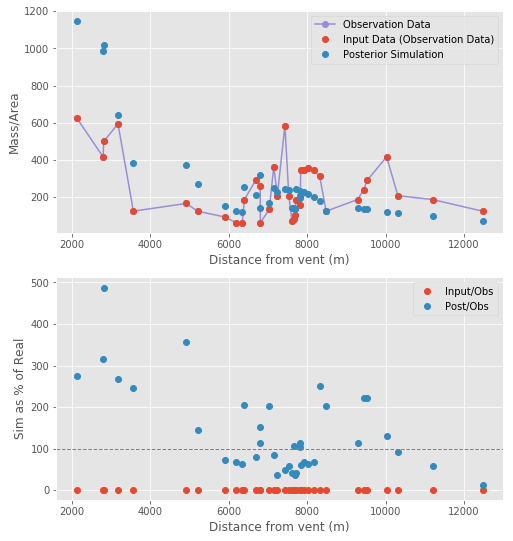

In [45]:
for name, params, mass, in_data in zip(names, params_list, inverted_masses_list, data_sets):
    print("========%s========"%name)
    q_dist = beta(params["a"],params["b"])

    grid = obs_df[["Easting", "Northing"]]
    u = params["u"]
    v = params["v"]
    post_df = gaussian_stack_forward(
        grid, int(config["COL_STEPS"]), config["VENT_ELEVATION"], 
        params["h1"], 2500, phi_steps, (params["a"],params["b"]), config["ERUPTION_MASS"], 
        (u,v), config["DIFFUSION_COEFFICIENT"], config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"]
    )
    
    post_df["radius"] = np.sqrt(post_df["Easting"]**2 + post_df["Northing"]**2)
    post_df = post_df.sort_values(by=['radius'])
    post_df["Residual"] = post_df["MassArea"]/obs_df["MassArea"]*100
    post_df["Change"] = post_df["MassArea"]/in_data["MassArea"]*100
    
    fig, axs = plt.subplots(2,2, figsize=(
            10, 10), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    
    vis.plot_sample(in_data, vent=(0,0), log=False, 
                title="Input Dataset (%s)"%name, cbar_label="Mass/Area", ax=axs[0])
    vis.plot_sample(post_df, vent=(0,0), log=False, 
                title="Posterior Simulation", cbar_label="Mass/Area", ax=axs[1])
    vis.plot_sample(post_df, vent=(0,0), log=False, values="Change",
                title="Input Data Residual", cbar_label="Mass/Area", ax=axs[2])
    vis.plot_sample(post_df, vent=(0,0), log=False, values="Residual",
                title="Observation Data Residual", cbar_label="Mass/Area", ax=axs[3])

    plt.tight_layout()
    plt.show()

    
    fig, axs = plt.subplots(2,1, figsize=(
            8, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C2o-', label="Observation Data")
    axs[0].plot(in_data["radius"].values, in_data["MassArea"].values, 'C0o', label="Input Data (%s)"%name)
    axs[0].plot(post_df["radius"].values, post_df["MassArea"].values, 'C1o', label="Posterior Simulation")
    axs[0].legend()
    axs[0].set_xlabel("Distance from vent (m)")
    axs[0].set_ylabel("Mass/Area")


    axs[1].plot(in_data["radius"].values, in_data["Residual"].values, 'C0o', label="Input/Obs")
    axs[1].plot(post_df["radius"].values, post_df["Residual"].values, 'C1o', label="Post/Obs")
    axs[1].axhline(100, linestyle="--", lw=1, c="gray")
    axs[1].legend()
    axs[1].set_xlabel("Distance from vent (m)")
    axs[1].set_ylabel("Sim as % of Real")
    plt.show()
    

In [ ]:


a = [1,2,3,4,5,6]

b, c, d, \
    e, f, g = a

print(b, c, d, e, f, g)